In [1]:
import os, re, csv, math, glob, itertools, collections

# Algebra
import scipy
import numpy as np
from fractions import Fraction

# Tables
import pandas as pd

# Graph
import graphtools
import networkx as nx
from GraphRicciCurvature.FormanRicci import FormanRicci
from GraphRicciCurvature.OllivierRicci import OllivierRicci

# Visualization
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# PECAN
from pecan import data
from pecan import utilities

# TDA
from ripser import Rips
from pyrivet import rivet
import PersistenceImages.persistence_images as pimg

# ML
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import euclidean_distances

# Fast EMD Computation
from DiffusionEMD import DiffusionCheb
from DiffusionEMD.estimate_utils import l1_distance_matrix

#### Plot Settings

In [2]:
matplotlib.rc('axes', labelsize = 6)
matplotlib.rc('xtick', labelsize = 5) 
matplotlib.rc('ytick', labelsize = 5) 

#### Diffusion Condensation

In [3]:
class DiffusionCondensation:
    
    def __init__(self):
        
        self.kernel_fn = self.make_affinity_matrix
        
    def __call__(self, X, epsilon):
       
        n = X.shape[0]

        Q_prev = np.identity(n)
        Q_diff = np.inf

        X = X.copy()

        i = 0
        j = -2

        data = {
            'data_t_0': X.copy(),
            'P_t_0': np.identity(n),
        }
            
        while i - j > 1:

            j = i

            while Q_diff >= 1e-4:

                i += 1

                D = euclidean_distances(X)

                A = self.kernel_fn(X, epsilon)
                Q = np.sum(A, axis=1)
                K = np.diag(1.0 / Q) @ A @ np.diag(1.0 / Q)
                P = np.diag(1.0 / np.sum(K, axis=1)) @ K

                data[f'P_t_{i}'] = P
                data[f'D_t_{i}'] = D

                X = P @ X

                data[f'data_t_{i}'] = X.copy()

                Q_diff = np.max(Q - Q_prev)
                Q_prev = Q
                
            epsilon *= 2
            Q_diff = np.inf
            
        return data
            
    @staticmethod
    def make_affinity_matrix(X, epsilon):
        
        return rbf_kernel(X, gamma=1.0 / epsilon) 

#### Plotting

In [4]:
def plot_point_cloud_2d(X):
    plt.figure(figsize=(1.2,1.2), dpi=300, frameon=False)
    plt.scatter(X[:,0], X[:,1], s=0.1, color='k')
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")
    plt.axis("equal")
    plt.show()

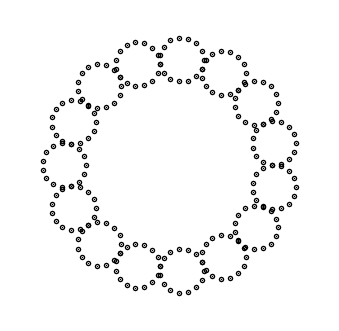

In [5]:
X = data.petals(250, random_state=1337)[0]
eps_estimate = utilities.estimate_epsilon(X)

%matplotlib inline
plot_point_cloud_2d(X)

In [6]:
DC = DiffusionCondensation()
dc_out = DC(X, eps_estimate)

In [7]:
def DC_plot(DC_data, t):
    plot_point_cloud_2d(dc_out[f'data_t_' + str(t)])

In [8]:
%matplotlib widget
interact(DC_plot, DC_data=fixed(dc_out), t=widgets.IntSlider(value=0,min=0,max=50,step=1));

interactive(children=(IntSlider(value=0, description='t', max=50), Output()), _dom_classes=('widget-interact',…

#### CROCKER Plot

In [9]:
def compute_Betti_numbers(dgm, eps_vals):
    
    if len(dgm) < 1:
        return 0
    
    dgm = np.array(dgm)

    betti_numbers = []
    
    for eps in eps_vals:
        
        betti_numbers.append(np.sum((dgm[:,0] < eps) & (dgm[:,1] > eps)))
        
    return betti_numbers

t_max = 50
num_eps = 100
eps = np.linspace(0.01, 1, num_eps)

CROCKER_H0 = np.zeros((num_eps, t_max))
CROCKER_H1 = np.zeros((num_eps, t_max))

for t in range(t_max):
    
    X = dc_out[f'data_t_' + str(t)]
    
    rips = Rips(maxdim=1, verbose=False)
    dgms = rips.fit_transform(X)
    
    H0_dgm = dgms[0]
    H1_dgm = dgms[1]
    
    CROCKER_H0[:,t] = compute_Betti_numbers(H0_dgm, eps)
    CROCKER_H1[:,t] = compute_Betti_numbers(H1_dgm, eps)

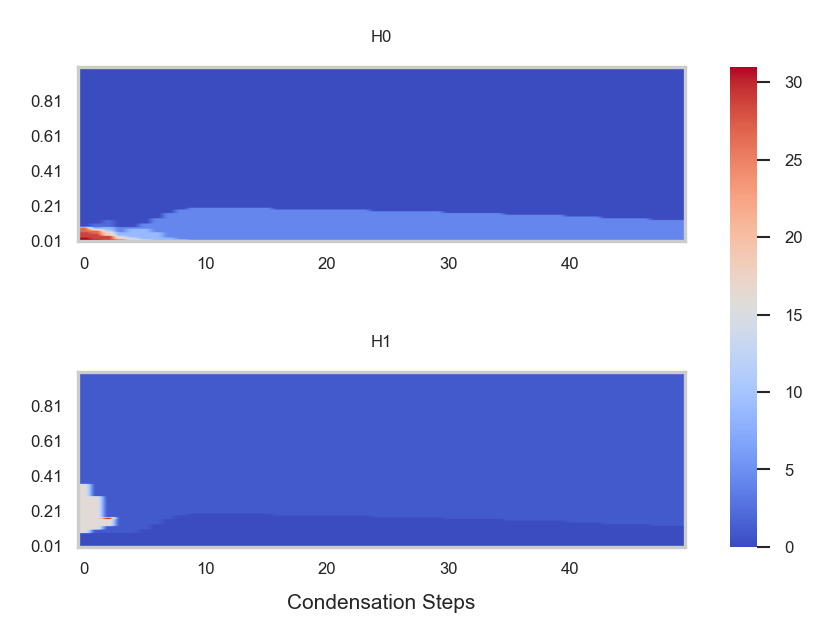

In [11]:
%matplotlib inline

xtickpos = np.arange(0, t_max, 10)
ytickpos = np.arange(0.0, num_eps, 20)
ytickvals = [np.round(eps[int(pos)], 3) for pos in ytickpos]

fig = plt.figure(figsize=(3,2), dpi=300, frameon=False)
plots = fig.subplots(1, 2, sharex=True, sharey=True)

plt.subplot(211)
plt.title("H0", fontsize=4)
plt.imshow(CROCKER_H0, origin="lower", aspect='auto', cmap='coolwarm')
ax = plt.gca()
ax.tick_params(axis='both', which='major', pad=0.2)
plt.xticks(xtickpos, xtickpos, fontsize=4)
plt.yticks(ytickpos, ytickvals, fontsize=4)
plt.grid(False)

plt.subplot(212)
plt.title("H1", fontsize=4)
plt.imshow(CROCKER_H1, origin="lower", aspect='auto', cmap='coolwarm')
ax = plt.gca()
ax.tick_params(axis='both', which='major', pad=0.2)
plt.xticks(xtickpos, xtickpos, fontsize=4)
plt.yticks(ytickpos, ytickvals, fontsize=4)
plt.xlabel('Condensation Steps', fontsize=5)
plt.grid(False)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.03, 0.8])
cbar = plt.colorbar(cax=cax)
cbar.ax.tick_params(labelsize=4, length=3, width=0.5)
cbar.outline.set_linewidth(0)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.75)

plt.show()

#### Ollivier Ricci Curvature filtration

In [13]:
X = data.petals(250, random_state=1337)[0]
tol = 1e-20

G = graphtools.graphs.kNNGraph(X, bandwidth=eps_estimate, decay=1)

# symmetric diffusion affinity matrix
P_symmetric = G.diff_aff.toarray()

num_nodes = X.shape[0]

G = nx.Graph()
for i in range(num_nodes):
    G.add_node(i, pos=(X[i,0], X[i,1]))
    
for i in range(num_nodes):
    for j in range(i):
        G.add_edge(i, j, weight=-1.0*math.log(P_symmetric[i,j] + tol))
        
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

Calculating KNN search...
Calculating affinities...


Compute Ricci curvature with probability distribution:

$$ m_x(x_i) = \begin{cases}
              \alpha & \mbox{if } x_i = x  \\
              \frac{1-\alpha}{C} b^{-d(x,x_i)^p} & x_i \in \pi(x) \\
              0 & \text{otherwise}
              \end{cases}$$

where, $C = \sum_{x_i \in \pi(x)} b^{-d(x,x_i)^p}$

In [14]:
orc = OllivierRicci(G, alpha=0.5, base=math.e, exp_power=1, proc=8, verbose="INFO")

In [15]:
orc.compute_ricci_curvature()
G_orc = orc.G.copy()
ORC_edges = nx.get_edge_attributes(G_orc, "ricciCurvature").values()
ORC_nodes = nx.get_node_attributes(G_orc, "ricciCurvature").values()

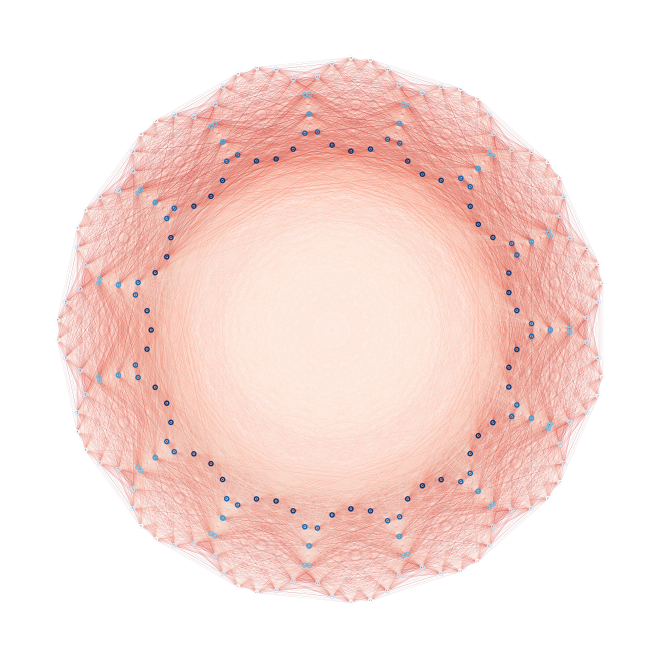

In [16]:
%matplotlib inline
plt.figure(figsize=(2,2), dpi=300, frameon=False)
nx.draw(G_orc, nx.get_node_attributes(G, 'pos'), with_labels=False, edgelist=edges, width=0.01, node_size=0.1, 
        edge_color=list(ORC_edges), edge_cmap=plt.cm.Reds, node_color=list(ORC_nodes), cmap=plt.cm.Blues)

#### Function-Rips bifiltration

For $P$ a finite metric space and $r \ge 0$ , let $N(P)_r$ denote the $r$-neighborhood graph of $P$:

- the vertex set of $N(P)_r$ is $P$
- edge $[i,j] \in N(P)_r$ if and only if $d(i,j) \le r$ 
- if $r < 0$, we define $N(P) := \emptyset$

We define the *Vietoris-Rips complex* $R(P)_r$ to be the clique complex on $N(P)_r$, i.e. the largest simplical complex with 1-skeleton $N(P)_r$.

Given any function $\gamma: P \to \mathbb{R}$, we define the *function-Rips bifiltration* $\text{FR}(\gamma)$ as follows:

$$ \text{FR}(\gamma)_{a,b} = R(\gamma^{-1}(-\infty,a])_b $$

#### Invariants 
- fibered barcode
- bigraded Betti numbers

In [17]:
with open('/tmp/petals_ORC.txt', 'w') as f:
    
    f.write("--datatype points_fn\n")
    
    func_vals = " ".join([str(ORC_val) for ORC_val in list(ORC_nodes)])
    f.write("%s\n" % func_vals)
    
    for itr in range(num_nodes):
        f.write(str(X[itr,0]) + ' ' + str(X[itr,1]) + "\n")

In [18]:
slices = [(45,-0.2),(45,-0.1),(45,0.0),(45,0.1)]

computed_file_path = rivet.compute_file('/tmp/petals_ORC.txt', homology=0, x=150, y=150)

with open(computed_file_path, 'rb') as f:
    computed_data = f.read()
    
H0_codes = rivet.barcodes(computed_data, slices)

computed_file_path = rivet.compute_file('/tmp/petals_ORC.txt', homology=1, x=150, y=150)

with open(computed_file_path, 'rb') as f:
    computed_data = f.read()
    
H1_codes = rivet.barcodes(computed_data, slices)

In [19]:
pers_imager = pimg.PersistenceImager()
pers_imager.pixel_size = 0.05
pers_imager.birth_range = (0, 0.5)
pers_imager.pers_range = (0, 1)
pers_imager.weight = pimg.weighting_fxns.persistence
pers_imager.weight_params = {'n': 2}
pers_imager.kernel_params = {'sigma': 0.5}
print(pers_imager)

PersistenceImager object: 
  pixel size: 0.05 
  resolution: (10, 20) 
  birth range: (0, 0.5) 
  persistence range: (0, 1) 
  weight: persistence 
  kernel: bvncdf 
  weight parameters: {n: 2} 
  kernel parameters: {sigma: 0.5}


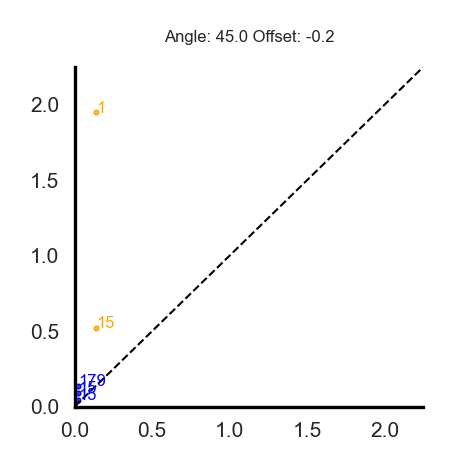

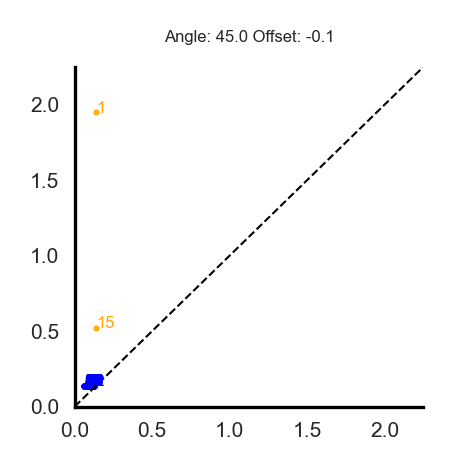

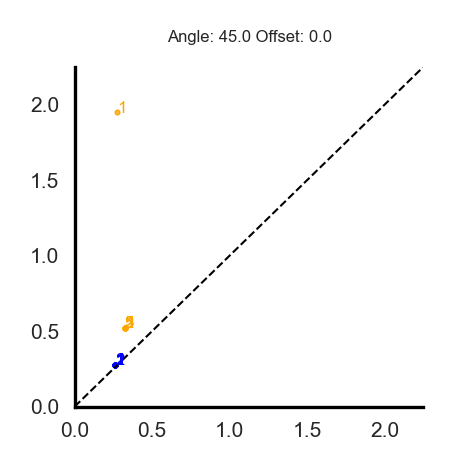

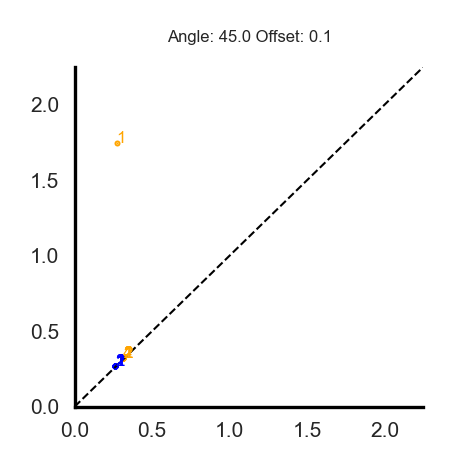

In [20]:
%matplotlib inline

for slice_1d in range(len(slices)):
    
    angle = H0_codes[slice_1d][0][0]
    offset = H0_codes[slice_1d][0][1]
    
    H0_fibred_barcode = H0_codes[slice_1d][1]
    H0_fibred_barcode = H0_fibred_barcode.to_array()
    
    H1_fibred_barcode = H1_codes[slice_1d][1]
    H1_fibred_barcode = H1_fibred_barcode.to_array()
    
    # create persistence diagram
    
    dgm = [[], []]
    
    plt.figure(figsize=(1.5,1.5), dpi=300)
    plt.title("Angle: " + str(angle) + " Offset: " + str(offset), fontsize=4)
    plt.plot([0, 2.5], [0, 2.5], 'k--', linewidth=0.5)

    for idx in range(len(H0_fibred_barcode)):
        if (H0_fibred_barcode[idx][1] == np.inf):
            dgm[0].append([0, 1])
        else:
            plt.scatter(H0_fibred_barcode[idx][0], H0_fibred_barcode[idx][1], s=0.2, color='b')
            plt.text(H0_fibred_barcode[idx][0], H0_fibred_barcode[idx][1], 
                     s=str(int(H0_fibred_barcode[idx][2])), color='b', fontsize=4)
            multiplicity = 1
            while multiplicity <= H0_fibred_barcode[idx][2]:
                dgm[0].append([H0_fibred_barcode[idx][0], H0_fibred_barcode[idx][1]])
                multiplicity += 1
                
    for idx in range(len(H1_fibred_barcode)):
        plt.scatter(H1_fibred_barcode[idx][0], H1_fibred_barcode[idx][1], s=0.2, color='orange')
        plt.text(H1_fibred_barcode[idx][0], H1_fibred_barcode[idx][1], 
                 s=str(int(H1_fibred_barcode[idx][2])), color='orange', fontsize=4)
        multiplicity = 1
        while multiplicity <= H1_fibred_barcode[idx][2]:
            dgm[1].append([H1_fibred_barcode[idx][0], H1_fibred_barcode[idx][1]])
            multiplicity += 1
     
    plt.xlim([0, 2.25])
    plt.ylim([0, 2.25])
    ax = plt.gca()
    ax.spines["left"].set_color('k')
    ax.spines["bottom"].set_color('k')
    ax.spines["top"].set_color('None')
    ax.spines["right"].set_color('None')
    ax.tick_params(axis='both', which='major', pad=0.2)
    plt.grid(False)
    plt.show()
    
    # persistence image
    #H0_pers_img_bp = pers_imager.transform(dgm[0], skew=True)
    #H1_pers_img_bp = pers_imager.transform(dgm[1], skew=True)

In [21]:
h0_betti = rivet.betti_file('/tmp/petals_ORC.txt', homology=0, x=150, y=150)
h1_betti = rivet.betti_file('/tmp/petals_ORC.txt', homology=1, x=150, y=150)

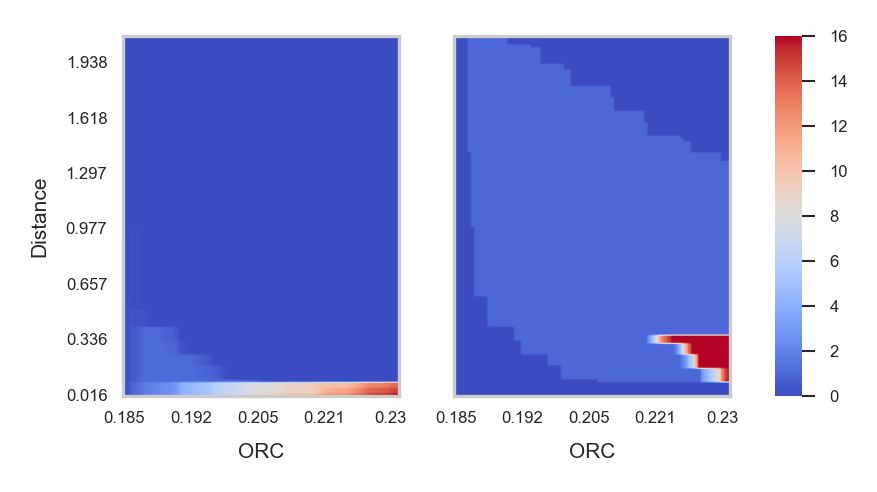

In [22]:
%matplotlib inline

x_grades = [float(x_grade) for x_grade in h0_betti.dimensions.x_grades]
y_grades = [float(y_grade) for y_grade in h0_betti.dimensions.y_grades]

xtickpos = np.arange(0, len(x_grades), 20)
ytickpos = np.arange(0, len(y_grades), 20)
xtickvals = [np.round(x_grades[int(pos)], 3) for pos in xtickpos]
ytickvals = [np.round(y_grades[int(pos)], 3) for pos in ytickpos]

fig = plt.figure(figsize=(3,1.5), dpi=300, frameon=False)
plots = fig.subplots(1, 2, sharex=True, sharey=True)

plt.subplot(121)
plt.imshow(h0_betti.graded_rank, origin='lower', aspect='auto', cmap='coolwarm')
plt.grid(False)
ax = plt.gca()
ax.tick_params(axis='both', which='major', pad=0.2)
plt.xlabel('ORC', fontsize=5)
plt.ylabel('Distance', fontsize=5)
plt.xticks(xtickpos, xtickvals, fontsize=4)
plt.yticks(ytickpos, ytickvals, fontsize=4)

plt.subplot(122)
plt.imshow(h1_betti.graded_rank, origin='lower', aspect='auto', cmap='coolwarm')
plt.grid(False)
ax = plt.gca()
ax.tick_params(axis='both', which='major', pad=0.2)
plt.xticks(xtickpos, xtickvals, fontsize=4)
plt.xlabel('ORC', fontsize=5)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.03, 0.8])
cbar = plt.colorbar(cax=cax)
cbar.ax.tick_params(labelsize=4, length=3, width=0.5)
cbar.outline.set_linewidth(0)

plt.show()

In [23]:
frc = FormanRicci(G, verbose="INFO")

In [24]:
frc.compute_ricci_curvature()
G_frc = frc.G.copy()
FRC_edges = nx.get_edge_attributes(G_frc, "formanCurvature").values()
FRC_nodes = nx.get_node_attributes(G_frc, "formanCurvature").values()

Forman curvature (augmented) computation done.


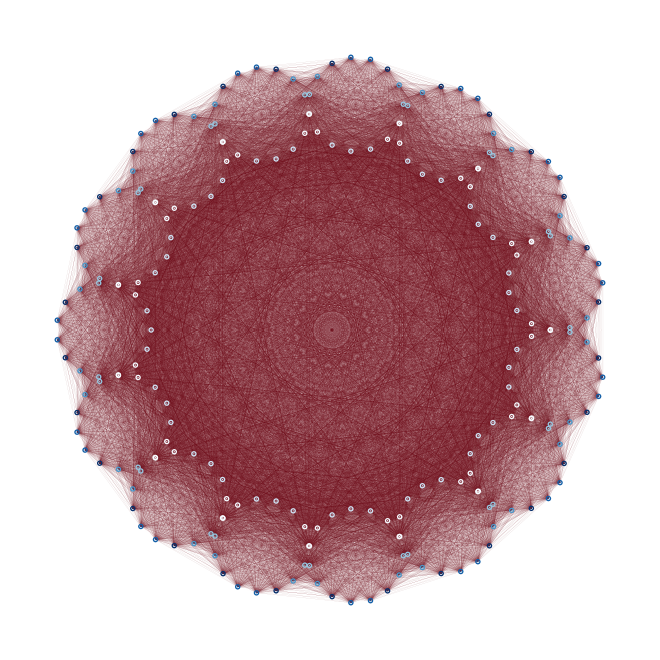

In [25]:
%matplotlib inline
plt.figure(figsize=(2,2), dpi=300, frameon=False)
nx.draw(G_frc, nx.get_node_attributes(G, 'pos'), with_labels=False, edgelist=edges, width=0.01, node_size=0.1, 
        edge_color=list(FRC_edges), edge_cmap=plt.cm.Reds, node_color=list(FRC_nodes), cmap=plt.cm.Blues)